# 미세 조정 분류 예시

두 스포츠를 구분하기 위해 에이다 분류기를 미세 조정합니다: 야구와 하키.

In [1]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import openai

categories = ['rec.sport.baseball', 'rec.sport.hockey']
sports_dataset = fetch_20newsgroups(subset='train', shuffle=True, random_state=42, categories=categories)

 ## 데이터 탐색
 뉴스 그룹 데이터 세트는 sklearn을 사용하여 로드할 수 있습니다. 먼저 데이터 자체를 살펴보겠습니다:

In [2]:
print(sports_dataset['data'][0])

From: dougb@comm.mot.com (Doug Bank)
Subject: Re: Info needed for Cleveland tickets
Reply-To: dougb@ecs.comm.mot.com
Organization: Motorola Land Mobile Products Sector
Distribution: usa
Nntp-Posting-Host: 145.1.146.35
Lines: 17

In article <1993Apr1.234031.4950@leland.Stanford.EDU>, bohnert@leland.Stanford.EDU (matthew bohnert) writes:

|> I'm going to be in Cleveland Thursday, April 15 to Sunday, April 18.
|> Does anybody know if the Tribe will be in town on those dates, and
|> if so, who're they playing and if tickets are available?

The tribe will be in town from April 16 to the 19th.
There are ALWAYS tickets available! (Though they are playing Toronto,
and many Toronto fans make the trip to Cleveland as it is easier to
get tickets in Cleveland than in Toronto.  Either way, I seriously
doubt they will sell out until the end of the season.)

-- 
Doug Bank                       Private Systems Division
dougb@ecs.comm.mot.com          Motorola Communications Sector
dougb@nwu.edu       

In [3]:
sports_dataset.target_names[sports_dataset['target'][0]]


'rec.sport.baseball'

In [4]:
len_all, len_baseball, len_hockey = len(sports_dataset.data), len([e for e in sports_dataset.target if e == 0]), len([e for e in sports_dataset.target if e == 1])
print(f"Total examples: {len_all}, Baseball examples: {len_baseball}, Hockey examples: {len_hockey}")

Total examples: 1197, Baseball examples: 597, Hockey examples: 600


야구 카테고리의 한 샘플을 위에서 볼 수 있습니다. 메일링 리스트에 보낸 이메일입니다. 총 1197개의 예가 있으며, 두 스포츠에 고르게 분포되어 있음을 알 수 있습니다.

## 데이터 준비
데이터 집합을 프롬프트와 완성을 위한 열이 있는 판다 데이터 프레임으로 변환합니다. 프롬프트에는 메일링 리스트의 이메일이 포함되고, 완성에는 하키 또는 야구와 같은 스포츠 이름이 포함됩니다. 데모 목적과 미세 조정 속도를 위해 300개의 예제만 사용합니다. 실제 사용 사례에서는 예제가 많을수록 성능이 향상됩니다.

In [5]:
import pandas as pd

labels = [sports_dataset.target_names[x].split('.')[-1] for x in sports_dataset['target']]
texts = [text.strip() for text in sports_dataset['data']]
df = pd.DataFrame(zip(texts, labels), columns = ['prompt','completion']) #[:300]
df.head()

,prompt,completion
0,From: dougb@comm.mot.com (Doug Bank)\nSubject:...,baseball
1,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,hockey
2,From: rudy@netcom.com (Rudy Wade)\nSubject: Re...,baseball
3,From: monack@helium.gas.uug.arizona.edu (david...,hockey
4,Subject: Let it be Known\nFrom: <ISSBTL@BYUVM....,baseball


야구와 하키는 모두 단일 토큰입니다. 데이터 집합을 jsonl 파일로 저장합니다.

In [6]:
df.to_json("sport2.jsonl", orient='records', lines=True)

### 데이터 준비 도구
이제 미세 조정 전에 데이터 세트에 대한 몇 가지 개선 사항을 제안하는 데이터 준비 도구를 사용할 수 있습니다. 도구를 실행하기 전에 최신 데이터 준비 도구를 사용하고 있는지 확인하기 위해 openai 라이브러리를 업데이트합니다. 또한 모든 제안을 자동으로 수락하는 `-q`를 추가로 지정합니다.

In [7]:
!pip install --upgrade openai

In [8]:
!openai tools fine_tunes.prepare_data -f sport2.jsonl -q

Analyzing...

- Your file contains 1197 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- There are 11 examples that are very long. These are rows: [134, 200, 281, 320, 404, 595, 704, 838, 1113, 1139, 1174]
For conditional generation, and for classification the examples shouldn't be longer than 2048 tokens.
- Your data does not contain a common separator at the end of your prompts. Having a separator string appended to the end of the prompt makes it clearer to the fine-tuned model where the completion should begin. See https://beta.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples. If you intend to do open-ended generation, then you should leave the prompts empty

이 도구는 데이터 세트에 대한 몇 가지 개선 사항을 제안하고 데이터 세트를 학습 및 검증 세트로 분할합니다.

프롬프트와 완성어 사이의 접미사는 입력 텍스트가 멈췄으며 이제 클래스를 예측해야 한다는 것을 모델에 알려주는 데 필요합니다. 각 예제에서 동일한 구분 기호를 사용했기 때문에 모델은 구분 기호 다음에 야구 또는 하키를 예측해야 한다는 것을 학습할 수 있습니다.
대부분의 단어 토큰은 공백 접두사로 토큰화되기 때문에 완성에 공백 접두사를 사용하는 것이 유용합니다.
또한 이 도구는 분류 작업일 가능성이 높다는 점을 인식하여 데이터 세트를 학습 데이터 세트와 검증 데이터 세트로 분할할 것을 제안했습니다. 이렇게 하면 새로운 데이터에 대한 예상 성능을 쉽게 측정할 수 있습니다.

## 미세 조정
이 도구는 다음 명령을 실행하여 데이터 집합을 훈련할 것을 제안합니다. 이것은 분류 작업이므로, 제공된 유효성 검사 집합에 대한 일반화 성능이 분류 사용 사례에 대해 어느 정도인지 알고 싶습니다. 이 도구는 분류 메트릭을 계산하기 위해 `--compute_classification_metrics --classification_positive_class " baseball"`을 추가할 것을 제안합니다.

CLI 도구에서 제안된 명령을 복사하기만 하면 됩니다. 특히 `-m ada`를 추가하여 분류 사용 사례에서 일반적으로 더 느리고 비싼 모델과 성능 면에서 대등한 더 저렴하고 빠른 ada 모델을 미세 조정할 수 있습니다.

In [9]:
!openai api fine_tunes.create -t "sport2_prepared_train.jsonl" -v "sport2_prepared_valid.jsonl" --compute_classification_metrics --classification_positive_class " baseball" -m ada

Upload progress: 100%|████████████████████| 1.52M/1.52M [00:00<00:00, 1.81Mit/s]
Uploaded file from sport2_prepared_train.jsonl: file-Dxx2xJqyjcwlhfDHpZdmCXlF
Upload progress: 100%|███████████████████████| 388k/388k [00:00<00:00, 507kit/s]
Uploaded file from sport2_prepared_valid.jsonl: file-Mvb8YAeLnGdneSAFcfiVcgcN
Created fine-tune: ft-2zaA7qi0rxJduWQpdvOvmGn3
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2021-07-30 13:15:50] Created fine-tune: ft-2zaA7qi0rxJduWQpdvOvmGn3
[2021-07-30 13:15:52] Fine-tune enqueued. Queue number: 0
[2021-07-30 13:15:56] Fine-tune started
[2021-07-30 13:18:55] Completed epoch 1/4
[2021-07-30 13:20:47] Completed epoch 2/4
[2021-07-30 13:22:40] Completed epoch 3/4
[2021-07-30 13:24:31] Completed epoch 4/4
[2021-07-30 13:26:22] Uploaded model: ada:ft-openai-2021-07-30-12-26-20
[2021-07-30 13:26:27] Uploaded result file: file-6Ki9RqLQwkChGsr9CHcr1ncg
[2021-07-30 13:26:28] Fine-tune succee

약 10분 만에 모델이 성공적으로 학습되었습니다. 모델 이름이 `ada:ft-openai-2021-07-30-12-26-20`임을 알 수 있으며, 추론에 사용할 수 있습니다.

### [고급] 결과 및 예상 모델 성능
이제 결과 파일을 다운로드하여 보류된 유효성 검사 세트에서 예상되는 성능을 관찰할 수 있습니다.

In [10]:
!openai api fine_tunes.results -i ft-2zaA7qi0rxJduWQpdvOvmGn3 > result.csv

In [11]:
results = pd.read_csv('result.csv')
results[results['classification/accuracy'].notnull()].tail(1)

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,classification/accuracy,classification/precision,classification/recall,classification/auroc,classification/auprc,classification/f1.0,validation_loss,validation_sequence_accuracy,validation_token_accuracy
929,930,3027688,3720,0.044408,1.0,1.0,0.991597,0.983471,1.0,1.0,1.0,0.991667,NaN,NaN,NaN


정확도는 99.6%에 이릅니다. 아래 그림에서 훈련 실행 중에 유효성 검사 집합의 정확도가 어떻게 증가하는지 확인할 수 있습니다.

<AxesSubplot:>

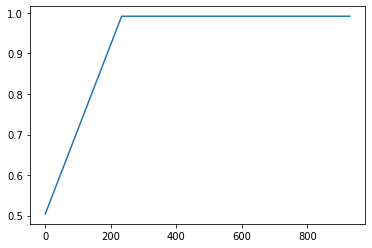

In [12]:
results[results['classification/accuracy'].notnull()]['classification/accuracy'].plot()

## 모델 사용하기
이제 모델을 호출하여 예측을 가져올 수 있습니다.

In [13]:
test = pd.read_json('sport2_prepared_valid.jsonl', lines=True)
test.head()

,prompt,completion
0,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,hockey
1,From: smorris@venus.lerc.nasa.gov (Ron Morris ...,hockey
2,From: golchowy@alchemy.chem.utoronto.ca (Geral...,hockey
3,From: krattige@hpcc01.corp.hp.com (Kim Krattig...,baseball
4,From: warped@cs.montana.edu (Doug Dolven)\nSub...,baseball


미세 조정할 때 사용한 프롬프트 다음에 동일한 구분 기호를 사용해야 합니다. 이 경우 `\n\n###\n\n`입니다. 우리는 분류에 관심이 있으므로 온도를 가능한 한 낮추고, 모델의 예측을 결정하기 위해 단 한 번의 토큰 완료만 요구합니다.

In [14]:
ft_model = 'ada:ft-openai-2021-07-30-12-26-20'
res = openai.Completion.create(model=ft_model, prompt=test['prompt'][0] + '\n\n###\n\n', max_tokens=1, temperature=0)
res['choices'][0]['text']


' hockey'

로그 확률을 얻으려면 완료 요청에 로그 프로브 파라미터를 지정하면 됩니다.

In [15]:
res = openai.Completion.create(model=ft_model, prompt=test['prompt'][0] + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['logprobs']['top_logprobs'][0]

<OpenAIObject at 0x7fe114e435c8> JSON: {
  " baseball": -7.6311407,
  " hockey": -0.0006307676
}

모델이 야구보다 하키를 훨씬 더 많이 예측하는 것을 볼 수 있으며, 이는 올바른 예측입니다. log_probs를 요청하면 각 클래스에 대한 예측(로그) 확률을 확인할 수 있습니다.

### 일반화
흥미롭게도 미세 조정된 분류기는 매우 다재다능합니다. 다양한 메일링 리스트에 대한 이메일에 대해 학습되었음에도 불구하고 트윗도 성공적으로 예측합니다.

In [16]:
sample_hockey_tweet = """Thank you to the 
@Canes
 and all you amazing Caniacs that have been so supportive! You guys are some of the best fans in the NHL without a doubt! Really excited to start this new chapter in my career with the 
@DetroitRedWings
 !!"""
res = openai.Completion.create(model=ft_model, prompt=sample_hockey_tweet + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['text']

' hockey'

In [17]:
sample_baseball_tweet="""BREAKING: The Tampa Bay Rays are finalizing a deal to acquire slugger Nelson Cruz from the Minnesota Twins, sources tell ESPN."""
res = openai.Completion.create(model=ft_model, prompt=sample_baseball_tweet + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['text']

' baseball'